In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from datetime import datetime
from keystroke_module import *

In [ ]:
# TO DO: kontrola bledow np. w konstruktorze klasy -?
# zalozenie minimalnej dlugosci: 100 czy 150? (bo wynika ze w ciagu 6min z 1.datasetu najmniej to 107 i 117 po filtracji, reszta co najmniej 150 kikniec, srednio na osobe wychodzi 600)

## Read data - (1. dataset)

Patients with PD:  42
Patients without PD:  43


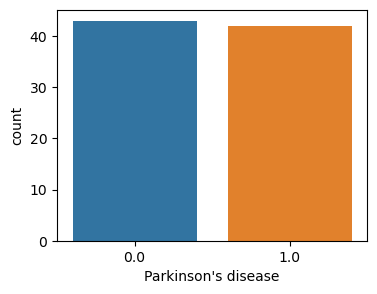

In [3]:
filename1 = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv'
filename2 = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv'
path = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/all/'

data1 = nqDataset(filename1, filename2)
data1.show_stats()

In [3]:
data1.prepare_dataset(path, feature_extract=1)
print(data1.trainset.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
(59, 6)


In [5]:
data1.train_ground_truth

array([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1.])

In [4]:
data1.trainset

array([[7.77777778e-01, 4.91115765e-01, 1.35646274e-01, 8.27980446e-01,
        3.31465687e-02, 3.22671156e-03],
       [1.61111111e+00, 3.88830668e-01, 9.37251882e-01, 6.27481178e-02,
        0.00000000e+00, 0.00000000e+00],
       [7.22222222e-01, 3.95279477e-01, 2.78336795e-01, 7.07666968e-01,
        1.10722611e-02, 2.92397661e-03],
       [7.22222222e-01, 4.73846352e-01, 6.92756293e-01, 3.07243707e-01,
        0.00000000e+00, 0.00000000e+00],
       [8.33333333e-01, 4.68356482e-01, 9.27336951e-01, 7.26630489e-02,
        0.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 4.54480076e-01, 7.89919291e-01, 2.07406912e-01,
        2.67379679e-03, 0.00000000e+00],
       [6.11111111e-01, 4.27028985e-01, 9.06345198e-01, 9.36548020e-02,
        0.00000000e+00, 0.00000000e+00],
       [1.83333333e+00, 4.81869594e-01, 7.91856404e-01, 2.07457725e-01,
        0.00000000e+00, 6.85871056e-04],
       [2.38888889e+00, 3.15737762e-01, 8.38313710e-01, 1.50958027e-01,
        8.81255364e-03, 

In [35]:
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# X of shape (n_samples, n_features) 
svc_model = SVC(C=10)
svc_model.fit(data1.trainset, data1.train_ground_truth)

SVC(C=10)

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(data1.trainset, data1.train_ground_truth)
print(grid.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

In [ ]:
svc_model = SVC(C=100, gamma=0.1)
svc_model.fit(data1.trainset, data1.train_ground_truth)

In [36]:
predictions = svc_model.predict(data1.testset)
print(predictions)
print(data1.test_ground_truth)

[0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1.]


In [37]:
print(accuracy_score(data1.test_ground_truth, predictions))
print(classification_report(data1.test_ground_truth, predictions))

0.6153846153846154
              precision    recall  f1-score   support

         0.0       0.53      0.73      0.62        11
         1.0       0.73      0.53      0.62        15

    accuracy                           0.62        26
   macro avg       0.63      0.63      0.62        26
weighted avg       0.65      0.62      0.62        26



In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(data1.trainset, data1.train_ground_truth)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [21]:
predictions = clf.predict(data1.testset)
print(predictions)
print(data1.test_ground_truth)

[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 1.]
[0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1.]


In [22]:
print(accuracy_score(data1.test_ground_truth, predictions))
print(classification_report(data1.test_ground_truth, predictions))

0.5769230769230769
              precision    recall  f1-score   support

         0.0       0.50      0.82      0.62        11
         1.0       0.75      0.40      0.52        15

    accuracy                           0.58        26
   macro avg       0.62      0.61      0.57        26
weighted avg       0.64      0.58      0.56        26



## Read data - (2. dataset TAPPY)

In [87]:
class tappyDataset:
    def __init__(self, path1, path2):

        # load data
        self.files_list1 = os.listdir(path1)
        self.files_list2 = os.listdir(path2)
        users = [el.split("_")[1].split(".")[0] for el in self.files_list1]
        df = pd.DataFrame(data=users, columns=['pID'])

        for i, el in enumerate(df['pID']):
            temp = [x for x in self.files_list2 if x.startswith(el)]
            if len(temp):
                df.loc[[i], 'files'] = pd.Series([temp], index=df.index[[i]])
                with open(path1 + self.files_list1[i], 'r') as f:
                    for line in f:
                        if 'Parkinsons' in line:
                            read_info = line.strip().split(": ")
                            df.loc[[i], 'Parkinsons'] = read_info[1]

        df.dropna(inplace=True)
        df['Parkinsons'] = df['Parkinsons'].map({'True': 1.0, 'False': 0.0})

        self.user_info = df

        # split for train and test
        self.train_df, self.test_df = train_test_split(
            self.user_info, test_size=0.3, random_state=42)

        self.train_ground_truth = self.train_df['Parkinsons'].to_numpy()
        self.test_ground_truth = self.test_df['Parkinsons'].to_numpy()
        self.trainset = None
        self.testset = None

    def show_stats(self):
        print('Patients with PD: ', len(
            self.user_info[self.user_info['Parkinsons'] == 1.0]))
        print('Patients without PD: ', len(
            self.user_info[self.user_info['Parkinsons'] == 0.0]))
        plt.figure(figsize=[4, 3])
        sns.countplot(x='Parkinsons', data=self.user_info)
        plt.xlabel('Parkinson\'s disease')

    @staticmethod
    def load_record(filename):
        df = pd.read_csv(filename, delimiter="\t", index_col=False, header=None, names=[
                         'User', 'Date', 'Timestamp', 'Hand', 'holdTime', 'Direction', 'flightTime', 'latencyTime'])

        df.drop(columns=['User'], inplace=True)
        df.drop(columns=['Direction'], inplace=True)

        df[df.columns[-3:]] = df[df.columns[-3:]
                                 ].apply(lambda x: x.lstrip('0') if type(x) == str else x)
        df[df.columns[-3:]
           ] = pd.to_numeric(df[df.columns[-3:]].stack(), errors='coerce').unstack()
        df[df.columns[-3:]] = df[df.columns[-3:]].apply(lambda x: x/1000)

        grouped_data = df.groupby('Date').agg(list)
        grouped_data['Length'] = grouped_data['Timestamp'].apply(len)

        idx = grouped_data['Length'].idxmax()
        ex_rec1 = df[df['Date'] == idx].copy()

        try:
            ex_rec1['Hour'] = ex_rec1['Timestamp'].apply(
                lambda x: datetime.strptime(x, '%H:%M:%S.%f').hour)
        except ValueError as ve:
            # TO DO: check procedure of format in column, remove wrong values
            print('Procedure')
            temp = ex_rec1['Timestamp'].apply(lambda x: is_date_parsing(x))
            ex_rec1.drop(ex_rec1[temp == False].index, inplace=True)
            ex_rec1['Hour'] = ex_rec1['Timestamp'].apply(
                lambda x: datetime.strptime(x, '%H:%M:%S.%f').hour)

        grouped_data = ex_rec1.groupby('Hour').agg(list)
        grouped_data['Length'] = grouped_data['Date'].apply(len)

        # jeśli jest odpowiednia liczba znakow
        if grouped_data['Length'].max() > 100:
            idx = grouped_data['Length'].idxmax()
            ex_rec2 = ex_rec1[ex_rec1['Hour'] == idx].copy()
            ex_rec2.drop('Hour', axis=1, inplace=True)
            ex_rec2.reset_index(inplace=True)

            ex_rec2['Timestamp'] = ex_rec2['Timestamp'].apply(
                lambda x: datetime.strptime(x, '%H:%M:%S.%f'))
            ex_rec2['timeLapse'] = count_time_from_0(ex_rec2)
        else:
            print('Not enough keystroke events!  ',
                  grouped_data['Length'].max())
            ex_rec2 = []

        return ex_rec2

    def prepare_dataset(self, path, feature_extract=2):

        flag_fatal = [0, 0]
        if feature_extract == 2:
            self.trainset = np.zeros([len(self.train_df), 22])

        for i, row in self.user_info.iterrows():
            # for i, row in self.train_df.reset_index(inplace=False).iterrows():
            # .iloc[45:]
            # DO NOT iterate: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
            # use .apply() instead
            
            # control
            print(i)
            if i==10:
                print(row['files'])

            # take first file not all, but if not enough ...
            df_ID = self.load_record(path + row['files'][0])
            if len(df_ID) == 0:
                if len(row['files']) > 1:
                    print('Another file was found!')
                    df_ID = self.load_record(path + row['files'][1])
                    if len(df_ID) == 0:
                        print('Fatal - record not useful, with gt: ',
                              row['Parkinsons'])
                        flag_fatal[0] += 1
                        flag_fatal[1] += row['Parkinsons']
                        continue
                    else:
                        print('Success')
                else:
                    print('Only 1 file is available!')
                    continue

            df_ID = filter_record(df_ID, key_filter=False)

            if feature_extract == 2:
                va_HT, rate = feature_extract_method_2(
                    df_ID, dynamic_feature='holdTime', time_feature='timeLapse', assumed_length=360, window_time=20)
                if rate >= 0.5:
                    flag_fatal[0] += 1
                    flag_fatal[1] += row['Parkinsons']
                va_NFT, _ = feature_extract_method_2(
                    df_ID, dynamic_feature='flightTime',  time_feature='timeLapse', assumed_length=360, window_time=20, normalize_option=True)
                self.trainset[i, :] = np.concatenate([va_HT, va_NFT], axis=0)

        print('flag_fatal: ', flag_fatal)

Patients with PD:  162
Patients without PD:  55


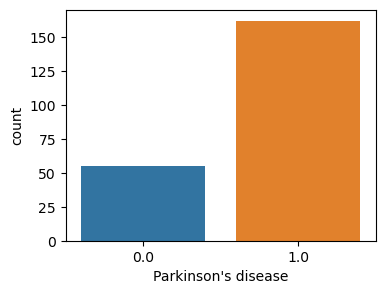

In [88]:
directory_path1 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Archived_users/'
directory_path2 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Tappy_Data/'

data2 = tappyDataset(directory_path1, directory_path2)
data2.show_stats()

In [ ]:
data2.prepare_dataset(directory_path2, feature_extract=2)
print(data2.trainset.shape)

In [58]:
data2.train_ground_truth

array([1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.])